# 1. Imports e definição de funções

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing as pp
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
import warnings
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
warnings.filterwarnings("ignore");

Função criada para avaliar o modelo com base em três parâmetros: Mean Absolute Error (MAE), Mean Squared Error (MSE) e Root Mean Squared Error (RMSE)

In [2]:
def ml_error(model_name,y,yhat):
    mae = mean_absolute_error(y,yhat)
    mse = mean_squared_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame({'Model Name':model_name,
                        'MAE':mae,
                        'MSE':mse,
                        'RMSE':rmse}, index=[0])

# 2. Carregamento de dados

Carregando os dados e utilizando a subamostragem sugerida:

In [16]:
df = pd.read_csv('jena_climate_2009_2016.csv')
df = df[5::6].reset_index(drop=True)

Checando o cabeçalho dos dados:

In [17]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
1,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
3,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
4,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


# 3. Análise exploratoria

Checando se há dados faltantes no dataset e se cada coluna esta com o tipo de dados correto. Percebe-se que a coluna Date Time está como object e não como datetime:

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70091 entries, 0 to 70090
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date Time        70091 non-null  object 
 1   p (mbar)         70091 non-null  float64
 2   T (degC)         70091 non-null  float64
 3   Tpot (K)         70091 non-null  float64
 4   Tdew (degC)      70091 non-null  float64
 5   rh (%)           70091 non-null  float64
 6   VPmax (mbar)     70091 non-null  float64
 7   VPact (mbar)     70091 non-null  float64
 8   VPdef (mbar)     70091 non-null  float64
 9   sh (g/kg)        70091 non-null  float64
 10  H2OC (mmol/mol)  70091 non-null  float64
 11  rho (g/m**3)     70091 non-null  float64
 12  wv (m/s)         70091 non-null  float64
 13  max. wv (m/s)    70091 non-null  float64
 14  wd (deg)         70091 non-null  float64
dtypes: float64(14), object(1)
memory usage: 8.0+ MB


Convertendo a coluna para datetime e verificando a distribuição de dados por ano:

In [19]:
df['Date Time'] = pd.to_datetime(df['Date Time'])

df['year']=df['Date Time'].dt.year

df[['year','Date Time']].groupby('year').count().reset_index()

,year,Date Time
0,2009,8759
1,2010,8784
2,2011,8760
3,2012,8784
4,2013,8760
5,2014,8774
6,2015,8760
7,2016,8710


Nas 2 próximas células, seleciono os atributos numéricos para verificar as distribuições dessas variáveis e também medidas estatísticas de tendência central e dispersão:

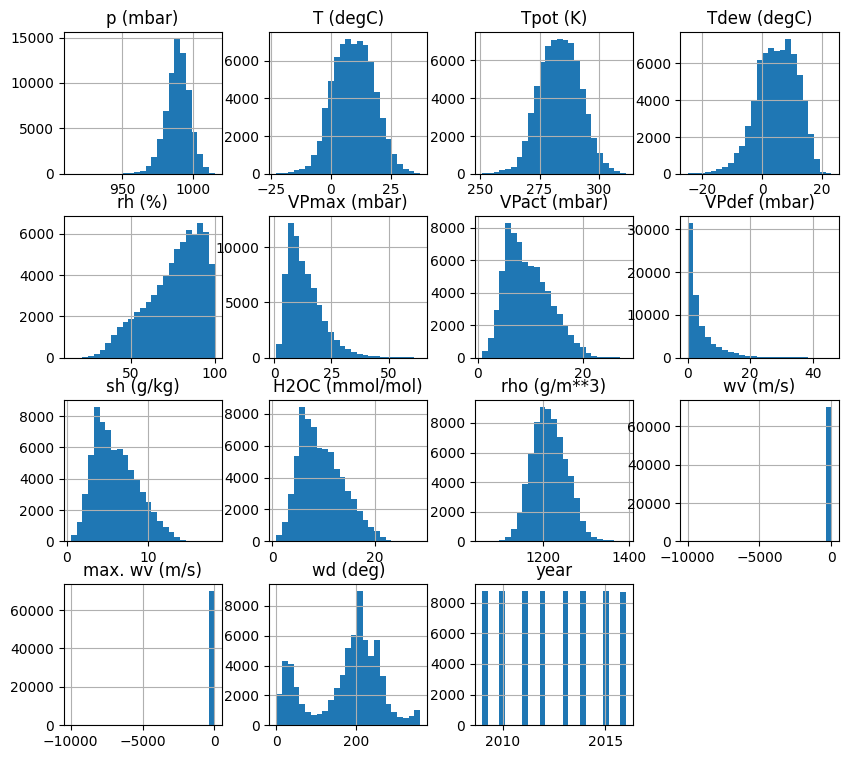

In [20]:
num_attributes = df.select_dtypes(include=['int64','float64'])

num_attributes.hist(bins=25,figsize=(10,9));

In [21]:
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T


m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns=['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,p (mbar),913.60,1015.29,101.69,989.212842,989.57,8.358826,-0.408400,0.947781
1,T (degC),-22.76,37.28,60.04,9.450482,9.41,8.423324,-0.019132,-0.200134
2,Tpot (K),250.85,311.21,60.36,283.493086,283.46,8.504363,-0.042367,-0.139266
3,Tdew (degC),-24.80,23.06,47.86,4.956471,5.21,6.730033,-0.377280,-0.019381
4,rh (%),13.88,100.00,86.12,76.009788,79.30,16.474803,-0.672906,-0.372463
5,VPmax (mbar),0.97,63.77,62.80,13.576576,11.82,7.739828,1.312609,2.409982
6,VPact (mbar),0.81,28.25,27.44,9.533968,8.86,4.183629,0.555974,-0.251760
7,VPdef (mbar),0.00,46.01,46.01,4.042536,2.19,4.898514,2.370334,7.409946
8,sh (g/kg),0.51,18.07,17.56,6.022560,5.59,2.655793,0.567294,-0.225700
9,H2OC (mmol/mol),0.81,28.74,27.93,9.640437,8.96,4.234832,0.560265,-0.237876


Aqui, ploto um gráfico de correlações para observar como essas variáveis se correlacionam:

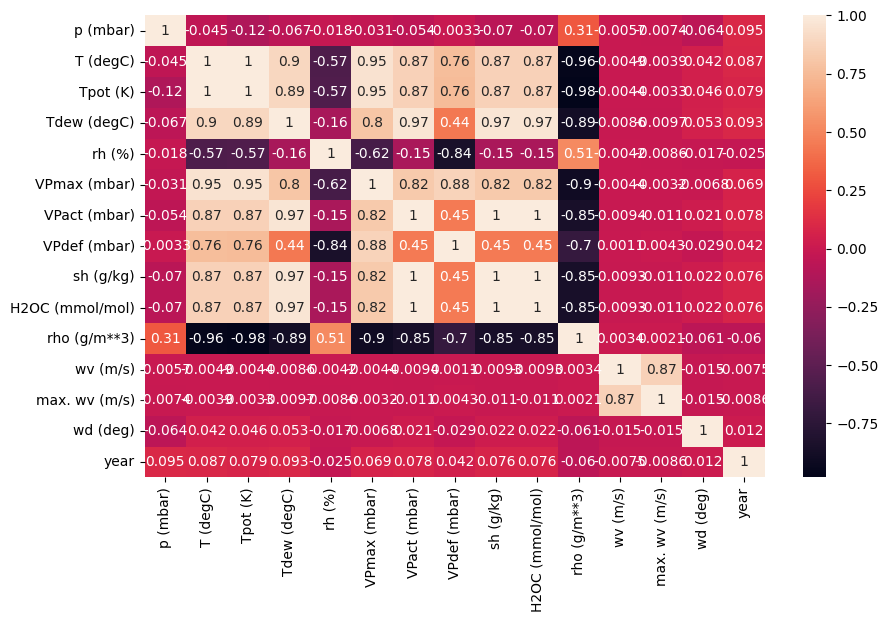

In [22]:
plt.figure(figsize=(10,6))
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation,annot=True);

Plotando a variável resposta no tempo para observar se há efeito periódico ou de sazonalidade:

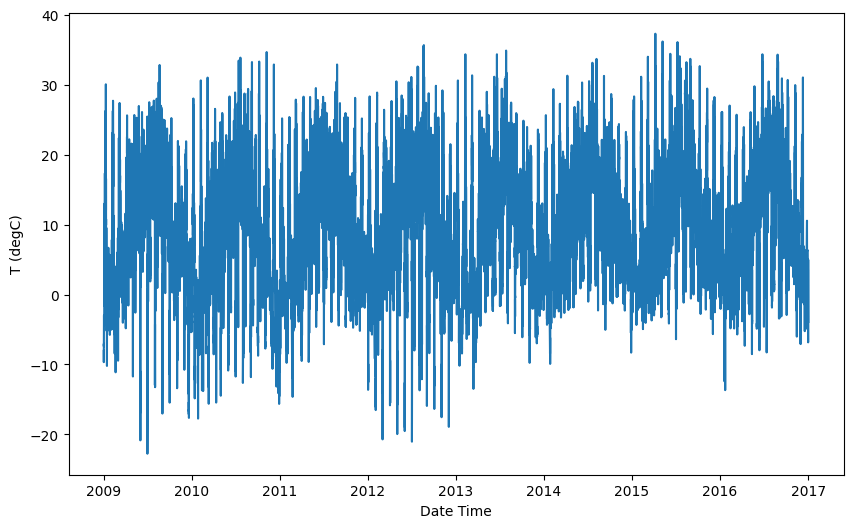

In [23]:
plt.figure(figsize=(10,6))
sns.lineplot( x='Date Time', y='T (degC)', data=df);

# 4. Engenharia de features

Aqui, removo algumas features consideradas como redundantes, não relevantes ou com potencial de target leak, levando em consideração o gráfico de correlação plotado anteriormente. Features removidas: Tpot (K), Tdew (degC), VPmax (mbar), sh (g/kg), wv (m/s), max. wv (m/s), wd (deg)

In [24]:
df1 = df.iloc[:,[0, 1, 2, 5, 7, 8, 10, 11]].copy()

Criando features novas relacionadas ao período de tempo. São elas: Trimestre, Mês, Semana do Ano, Dia e Hora

In [25]:
df1['quarter'] = df1['Date Time'].dt.quarter

df1['month'] = df1['Date Time'].dt.month

df1['week_of_year'] = df1['Date Time'].dt.isocalendar().week

df1['day'] = df1['Date Time'].dt.day

df1['hour'] = df1['Date Time'].dt.hour


# 5. Transformação de natureza

Para melhor capturar o elemento de periodicidade, é necessário transformar as features de data recém criadas.

Por exemplo, o mês 12 do ano de 2015 está mais perto do mês 1 de 2016 do que do mês 8 de 2015. Porém, os números brutos não refletem isso, visto que 12-8 = 4 < 12-1 = 11. Logo, deve-se transformar essa variável em um elemento cíclico. O mesmo vale para outras variáveis relacionadas ao tempo.

Minha solução para isso é utilizar o círculo trigonométrico, de maneira que o mês x passe a representar um ângulo. Ou seja, coloca-se cada mês em 1/12 do círculo trigonométrico. O mesmo vale para os outros períodos de tempo, deve-se colocar cada período distinto igualmente separado no círculo trigonométrico. 

Dessa maneira, podemos extrair o seno e o cosseno desses ângulos, que são duas propriedades que possuem períodos.

In [26]:
df1['quarter_sin'] = df1['quarter'].apply( lambda x: np.sin( x * ( 2. * np.pi/4 ) ) )
df1['quarter_cos'] = df1['quarter'].apply( lambda x: np.cos( x * ( 2. * np.pi/4 ) ) )

df1['month_sin'] = df1['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df1['month_cos'] = df1['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

df1['week_of_year_sin'] = df1['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df1['week_of_year_cos'] = df1['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

df1['day_sin'] = df1['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df1['day_cos'] = df1['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

df1['hour_sin'] = df1['hour'].apply( lambda x: np.sin( x * ( 2. * np.pi/24 ) ) )
df1['hour_cos'] = df1['hour'].apply( lambda x: np.cos( x * ( 2. * np.pi/24 ) ) )

Aqui, apago as features criadas anteriormente que não são mais necessárias visto que a transformação delas já foi feita:

In [27]:
df1.drop(['quarter','month','day','hour','week_of_year'],axis=1,inplace=True)

# 6. Split treino e teste

Como o modelo deve prever valores do futuro com relação à dados do passado, separei temporalmente treino e validação.

Treino: dados até 2014-12-31 23:00:00 (em torno de 75% do dataset)

Teste: dados a partir de 2015-01-01 01:00:00 (em torno de 25% do dataset)

Como solicitado, o modelo vai fazer previsões sobre dados de 2 horas após o dado mais recente do conjunto de treino.

In [28]:
X_train = df1[df1['Date Time'] < '2015-01-01 00:00:00']
y_train = X_train['T (degC)']
X_test = df1[df1['Date Time'] >= '2015-01-01 01:00:00']
y_test = X_test['T (degC)']

# 7. Reescala

Utilizei o Standard Scaler para fazer a reescala das variáveis preditoras, com base na distribuição vista pelo histograma anteriormente.

As variáveis apresentam, em maior ou menor grau, comportamentos semelhantes à uma distribuição normal e aparentam não possuir muitos outliers.

In [29]:
ss_pmbar = pp.StandardScaler()
ss_rh = pp.StandardScaler()
ss_vpact = pp.StandardScaler()
ss_vpdef = pp.StandardScaler()
ss_h2oc = pp.StandardScaler()
ss_rho = pp.StandardScaler()

In [30]:
X_train['p (mbar)'] = ss_pmbar.fit_transform(X_train[['p (mbar)']].values)
X_train['rh (%)'] = ss_rh.fit_transform(X_train[['rh (%)']].values)
X_train['VPact (mbar)'] = ss_vpact.fit_transform(X_train[['VPact (mbar)']].values)
X_train['VPdef (mbar)'] = ss_vpdef.fit_transform(X_train[['VPdef (mbar)']].values)
X_train['H2OC (mmol/mol)'] = ss_h2oc.fit_transform(X_train[['H2OC (mmol/mol)']].values)
X_train['rho (g/m**3)'] = ss_rho.fit_transform(X_train[['rho (g/m**3)']].values)

In [31]:
X_test['p (mbar)'] = ss_pmbar.transform(X_test[['p (mbar)']].values)
X_test['rh (%)'] = ss_rh.transform(X_test[['rh (%)']].values)
X_test['VPact (mbar)'] = ss_vpact.transform(X_test[['VPact (mbar)']].values)
X_test['VPdef (mbar)'] = ss_vpdef.transform(X_test[['VPdef (mbar)']].values)
X_test['H2OC (mmol/mol)'] = ss_h2oc.transform(X_test[['H2OC (mmol/mol)']].values)
X_test['rho (g/m**3)'] = ss_rho.transform(X_test[['rho (g/m**3)']].values)

# 8. Seleção de features

A seleção de features é um passo importante na construção do modelo, visto que ao eliminar features que não contribuem para a predição é possível reduzir tempo de treinamento e melhorar a performance do modelo.

Para esta tarefa utilizei o algoritmo Boruta, que é um Wrapper Method que seleciona as features mais relevantes para o modelo. 

Utilizei este algoritmo pois ele estabelece um parâmetro para determinar qual feature é ou não relevante, ao contrário de outros métodos onde é possível observar os valores de relevância mas fica à critério do usuário quais escolher.

Depois de rodar o algoritmo, juntei todos os nomes de colunas selecionadas em uma lista.

In [32]:
X_train_n = X_train.drop(['Date Time','T (degC)'],axis=1).values
y_train_n = y_train.values.ravel()
rf = RandomForestRegressor(n_jobs=-1)
boruta=BorutaPy(rf,n_estimators='auto',verbose=2, random_state=42).fit(X_train_n, y_train_n)
cols_selected = boruta.support_.tolist()
X_train_fs = X_train.drop(['Date Time','T (degC)'],axis=1)
cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.to_list()

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	6
Tentative: 	2
Rejected: 	8
Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	2
Rejected: 	8
Iteration: 	10 / 100
Confirmed: 	6
Tentative: 	2
Rejected: 	8
Iteration: 	11 / 100
Confirmed: 	6
Tentative: 	2
Rejected: 	8
Iteration: 	12 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	9
Iteration: 	13 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	9
Iteration: 	14 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	9
Iteration: 	15 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	9
Iteration: 	16 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	9
Iteration:

Abaixo estão as colunas selecionadas pelo algoritmo como relevantes. Destaca-se a coluna 'week_of_year_cos', uma feature criada por mim com base na data que muito provavelmente reflete a sazonalidade da temperatura.

In [33]:
cols_selected_boruta

['p (mbar)',
 'rh (%)',
 'VPact (mbar)',
 'VPdef (mbar)',
 'H2OC (mmol/mol)',
 'rho (g/m**3)',
 'week_of_year_cos']

Seleciono apenas as colunas consideradas como relevantes no dataset de treino e de teste:

In [49]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta].reset_index(drop=True)

In [50]:
x_train.head()

,p (mbar),rh (%),VPact (mbar),VPdef (mbar),H2OC (mmol/mol),rho (g/m**3),week_of_year_cos
0,0.95,1.09,-1.50,-0.79,-1.51,2.25,0.99
1,0.96,1.02,-1.56,-0.78,-1.57,2.36,0.99
2,0.99,1.04,-1.55,-0.78,-1.56,2.36,0.99
3,1.01,0.98,-1.57,-0.78,-1.58,2.40,0.99
4,1.07,0.96,-1.61,-0.78,-1.61,2.48,0.99


In [51]:
x_test.head()

,p (mbar),rh (%),VPact (mbar),VPdef (mbar),H2OC (mmol/mol),rho (g/m**3),week_of_year_cos
0,2.24,1.37,-0.56,-0.81,-0.60,1.33,0.99
1,2.28,1.36,-0.59,-0.81,-0.62,1.37,0.99
2,2.34,1.36,-0.62,-0.81,-0.65,1.41,0.99
3,2.33,1.38,-0.57,-0.81,-0.60,1.37,0.99
4,2.32,1.34,-0.54,-0.80,-0.57,1.32,0.99


# 9. Modelagem

Para a modelagem, testei três modelos de regressão: Regressão Linear, Random Forest e XGBoost. Escolhi esses modelos por já ter obtido resultados satisfatórios em projetos anteriores.

Nas métricas, utilizei o MAE, MSE e RMSE, que são métricas comumente utilizadas para avaliar modelos de regressão. O MAPE não foi utilizado pois existem temperaturas muito próximas a zero, de maneira que pela fórmula do MAPE essa métrica poderia tender a infinito em algumas situações. 

## Linear Regression

In [41]:
lr = LinearRegression().fit(x_train,y_train)
yhat_lr = lr.predict(x_test)
lr_result = ml_error('Linear Regression',y_test,yhat_lr)
lr_result

,Model Name,MAE,MSE,RMSE
0,Linear Regression,0.047995,0.005399,0.073481


## Random Forest

In [42]:
rf = RandomForestRegressor(random_state=42).fit(x_train,y_train)
yhat_rf = rf.predict(x_test)
rf_result = ml_error('Random Forest Regressor',y_test,yhat_rf)
rf_result

,Model Name,MAE,MSE,RMSE
0,Random Forest Regressor,0.062371,0.013338,0.115491


## XGBoost

In [43]:
model_xgb = xgb.XGBRegressor(random_state=42).fit( x_train, y_train )
yhat_xgb = model_xgb.predict( x_test )
xgb_result = ml_error( 'XGBoost Regressor', y_test,yhat_xgb)
xgb_result

,Model Name,MAE,MSE,RMSE
0,XGBoost Regressor,0.145007,0.037112,0.192645


# 10. Validação cruzada

Para atestar com mais certeza a superioridade do modelo de Regressão Linear para este projeto, resolvi dividir o dataset em 3 diferentes folds. Em cada fold, foi deixado um gap de 2 horas entre treino e teste, como solicitado.

Fold 1:

Treino: de 2009 a 2012

Teste:  de 2013 a 2014

Fold 2:

Treino: de 2010 a 2013

Teste:  de 2014 a 2015

Fold 3:

Treino: de 2011 a 2014

Teste:  de 2015 a 2016

## 10.1 Fold 1

In [52]:
X_train_fold1 = df1[df1['Date Time'] < '2013-01-01 00:00:00']
y_train_fold1 = X_train_fold1['T (degC)']
X_test_fold1 = df1[(df1['Date Time'] >= '2013-01-01 01:00:00') & (df1['Date Time'] < '2015-01-01 00:00:00')]
y_test_fold1 = X_test_fold1['T (degC)']

X_train_fold1['p (mbar)'] = ss_pmbar.fit_transform(X_train_fold1[['p (mbar)']].values)
X_train_fold1['rh (%)'] = ss_rh.fit_transform(X_train_fold1[['rh (%)']].values)
X_train_fold1['VPact (mbar)'] = ss_vpact.fit_transform(X_train_fold1[['VPact (mbar)']].values)
X_train_fold1['VPdef (mbar)'] = ss_vpdef.fit_transform(X_train_fold1[['VPdef (mbar)']].values)
X_train_fold1['H2OC (mmol/mol)'] = ss_h2oc.fit_transform(X_train_fold1[['H2OC (mmol/mol)']].values)
X_train_fold1['rho (g/m**3)'] = ss_rho.fit_transform(X_train_fold1[['rho (g/m**3)']].values)

X_test_fold1['p (mbar)'] = ss_pmbar.transform(X_test_fold1[['p (mbar)']].values)
X_test_fold1['rh (%)'] = ss_rh.transform(X_test_fold1[['rh (%)']].values)
X_test_fold1['VPact (mbar)'] = ss_vpact.transform(X_test_fold1[['VPact (mbar)']].values)
X_test_fold1['VPdef (mbar)'] = ss_vpdef.transform(X_test_fold1[['VPdef (mbar)']].values)
X_test_fold1['H2OC (mmol/mol)'] = ss_h2oc.transform(X_test_fold1[['H2OC (mmol/mol)']].values)
X_test_fold1['rho (g/m**3)'] = ss_rho.transform(X_test_fold1[['rho (g/m**3)']].values)

x_train_fold1 = X_train_fold1[cols_selected_boruta]
x_test_fold1 = X_test_fold1[cols_selected_boruta]

lr = LinearRegression().fit(x_train_fold1,y_train_fold1)
yhat_lr_fold1 = lr.predict(x_test_fold1)
lr_result = ml_error('Linear Regression',y_test_fold1,yhat_lr_fold1)
print(lr_result.iloc[0,:])

rf = RandomForestRegressor(random_state=42).fit(x_train_fold1,y_train_fold1)
yhat_rf_fold1 = rf.predict(x_test_fold1)
rf_result = ml_error('Random Forest Regressor',y_test_fold1,yhat_rf_fold1)
print(rf_result.iloc[0,:])

model_xgb = xgb.XGBRegressor(random_state=42).fit( x_train_fold1,y_train_fold1 )
yhat_xgb_fold1 = model_xgb.predict( x_test_fold1 )
xgb_result = ml_error( 'XGBoost Regressor', y_test_fold1,yhat_xgb_fold1)
print(xgb_result.iloc[0,:])

Model Name    Linear Regression
MAE                        0.05
MSE                        0.00
RMSE                       0.07
Name: 0, dtype: object
Model Name    Random Forest Regressor
MAE                              0.07
MSE                              0.02
RMSE                             0.13
Name: 0, dtype: object
Model Name    XGBoost Regressor
MAE                        0.15
MSE                        0.04
RMSE                       0.21
Name: 0, dtype: object


## 10.2 Fold 2

In [53]:
X_train_fold2 = df1[(df1['Date Time'] >= '2010-01-01 00:00:00') & (df1['Date Time'] < '2014-01-01 00:00:00')]
y_train_fold2 = X_train_fold2['T (degC)']
X_test_fold2 = df1[(df1['Date Time'] >= '2014-01-01 01:00:00') & (df1['Date Time'] < '2016-01-01 00:00:00')]
y_test_fold2 = X_test_fold2['T (degC)']

X_train_fold2['p (mbar)'] = ss_pmbar.fit_transform(X_train_fold2[['p (mbar)']].values)
X_train_fold2['rh (%)'] = ss_rh.fit_transform(X_train_fold2[['rh (%)']].values)
X_train_fold2['VPact (mbar)'] = ss_vpact.fit_transform(X_train_fold2[['VPact (mbar)']].values)
X_train_fold2['VPdef (mbar)'] = ss_vpdef.fit_transform(X_train_fold2[['VPdef (mbar)']].values)
X_train_fold2['H2OC (mmol/mol)'] = ss_h2oc.fit_transform(X_train_fold2[['H2OC (mmol/mol)']].values)
X_train_fold2['rho (g/m**3)'] = ss_rho.fit_transform(X_train_fold2[['rho (g/m**3)']].values)

X_test_fold2['p (mbar)'] = ss_pmbar.transform(X_test_fold2[['p (mbar)']].values)
X_test_fold2['rh (%)'] = ss_rh.transform(X_test_fold2[['rh (%)']].values)
X_test_fold2['VPact (mbar)'] = ss_vpact.transform(X_test_fold2[['VPact (mbar)']].values)
X_test_fold2['VPdef (mbar)'] = ss_vpdef.transform(X_test_fold2[['VPdef (mbar)']].values)
X_test_fold2['H2OC (mmol/mol)'] = ss_h2oc.transform(X_test_fold2[['H2OC (mmol/mol)']].values)
X_test_fold2['rho (g/m**3)'] = ss_rho.transform(X_test_fold2[['rho (g/m**3)']].values)

x_train_fold2 = X_train_fold2[cols_selected_boruta]
x_test_fold2 = X_test_fold2[cols_selected_boruta]

lr = LinearRegression().fit(x_train_fold2,y_train_fold2)
yhat_lr_fold2 = lr.predict(x_test_fold2)
lr_result = ml_error('Linear Regression',y_test_fold2,yhat_lr_fold2)
print(lr_result.iloc[0,:])

rf = RandomForestRegressor(random_state=42).fit(x_train_fold2,y_train_fold2)
yhat_rf_fold2 = rf.predict(x_test_fold2)
rf_result = ml_error('Random Forest Regressor',y_test_fold2,yhat_rf_fold2)
print(rf_result.iloc[0,:])

model_xgb = xgb.XGBRegressor(random_state=42).fit( x_train_fold2,y_train_fold2 )
yhat_xgb_fold2 = model_xgb.predict( x_test_fold2 )
xgb_result = ml_error( 'XGBoost Regressor', y_test_fold2,yhat_xgb_fold2)
print(xgb_result.iloc[0,:])

Model Name    Linear Regression
MAE                        0.05
MSE                        0.01
RMSE                       0.07
Name: 0, dtype: object
Model Name    Random Forest Regressor
MAE                              0.07
MSE                              0.02
RMSE                             0.13
Name: 0, dtype: object
Model Name    XGBoost Regressor
MAE                        0.15
MSE                        0.04
RMSE                       0.19
Name: 0, dtype: object


## 10.3 Fold 3

In [54]:
X_train_fold3 = df1[(df1['Date Time'] >= '2011-01-01 00:00:00') & (df1['Date Time'] < '2015-01-01 00:00:00')]
y_train_fold3 = X_train_fold3['T (degC)']
X_test_fold3 = df1[df1['Date Time'] >= '2015-01-01 01:00:00']
y_test_fold3 = X_test_fold3['T (degC)']

X_train_fold3['p (mbar)'] = ss_pmbar.fit_transform(X_train_fold3[['p (mbar)']].values)
X_train_fold3['rh (%)'] = ss_rh.fit_transform(X_train_fold3[['rh (%)']].values)
X_train_fold3['VPact (mbar)'] = ss_vpact.fit_transform(X_train_fold3[['VPact (mbar)']].values)
X_train_fold3['VPdef (mbar)'] = ss_vpdef.fit_transform(X_train_fold3[['VPdef (mbar)']].values)
X_train_fold3['H2OC (mmol/mol)'] = ss_h2oc.fit_transform(X_train_fold3[['H2OC (mmol/mol)']].values)
X_train_fold3['rho (g/m**3)'] = ss_rho.fit_transform(X_train_fold3[['rho (g/m**3)']].values)

X_test_fold3['p (mbar)'] = ss_pmbar.transform(X_test_fold3[['p (mbar)']].values)
X_test_fold3['rh (%)'] = ss_rh.transform(X_test_fold3[['rh (%)']].values)
X_test_fold3['VPact (mbar)'] = ss_vpact.transform(X_test_fold3[['VPact (mbar)']].values)
X_test_fold3['VPdef (mbar)'] = ss_vpdef.transform(X_test_fold3[['VPdef (mbar)']].values)
X_test_fold3['H2OC (mmol/mol)'] = ss_h2oc.transform(X_test_fold3[['H2OC (mmol/mol)']].values)
X_test_fold3['rho (g/m**3)'] = ss_rho.transform(X_test_fold3[['rho (g/m**3)']].values)

x_train_fold3 = X_train_fold3[cols_selected_boruta]
x_test_fold3 = X_test_fold3[cols_selected_boruta]

lr = LinearRegression().fit(x_train_fold3,y_train_fold3)
yhat_lr_fold3 = lr.predict(x_test_fold3)
lr_result = ml_error('Linear Regression',y_test_fold3,yhat_lr_fold3)
print(lr_result.iloc[0,:])

rf = RandomForestRegressor(random_state=42).fit(x_train_fold3,y_train_fold3)
yhat_rf_fold3 = rf.predict(x_test_fold3)
rf_result = ml_error('Random Forest Regressor',y_test_fold3,yhat_rf_fold3)
print(rf_result.iloc[0,:])

model_xgb = xgb.XGBRegressor(random_state=42).fit( x_train_fold3,y_train_fold3 )
yhat_xgb_fold3 = model_xgb.predict( x_test_fold3 )
xgb_result = ml_error( 'XGBoost Regressor', y_test_fold3,yhat_xgb_fold3)
print(xgb_result.iloc[0,:])

Model Name    Linear Regression
MAE                        0.05
MSE                        0.00
RMSE                       0.07
Name: 0, dtype: object
Model Name    Random Forest Regressor
MAE                              0.09
MSE                              0.04
RMSE                             0.19
Name: 0, dtype: object
Model Name    XGBoost Regressor
MAE                        0.15
MSE                        0.05
RMSE                       0.22
Name: 0, dtype: object


# 11. Visualizando a performance do modelo escolhido: Regressão Linear

O modelo escolhido foi o modelo de Regressão Linear, visto que apresentou as melhores métricas e também um tempo de execução bem menor do que os outros modelos testados.

In [55]:
resultado = pd.DataFrame()

Criando um DataFrame para observar os valores e comportamentos dos erros:

In [62]:
resultado['y'] = y_test
resultado['yhat'] = yhat_lr
resultado['date'] = X_test['Date Time']
resultado['error'] = resultado['y'] - resultado['yhat']

<AxesSubplot:xlabel='yhat', ylabel='error'>

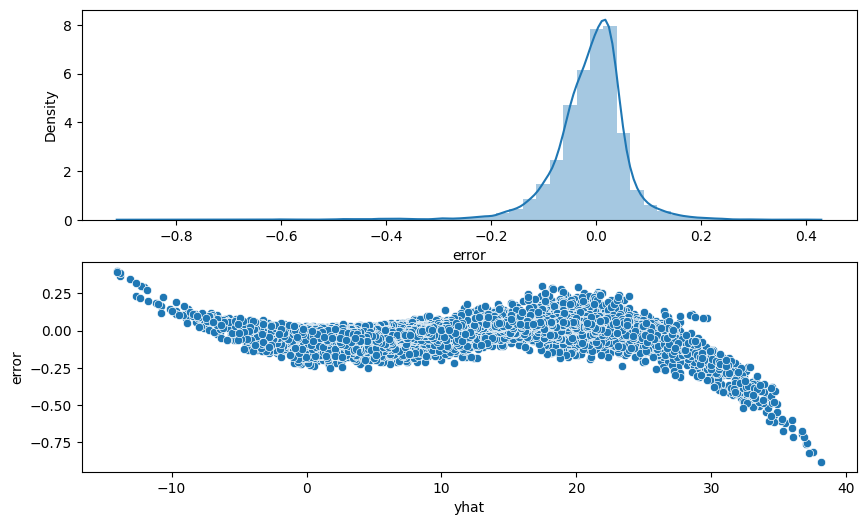

In [64]:
plt.figure(figsize=(10,6))

plt.subplot( 2, 1, 1 )
sns.distplot( resultado['error'] )

plt.subplot( 2, 1, 2 )
sns.scatterplot( resultado['yhat'], resultado['error'] )